# Cr-Ti-V

## Run feasibility tests on a ternary system with a plot


Imports

In [1]:
import os
import matplotlib.pyplot as plt
from pycalphad import Database, variables as v
from analysis_runner import run_simulation, plot_figure, EquilibriumSamplingPointsGenerator

T_liquid = 2200  # temperature where everything is liquid
potentials = {v.N: 1, v.T: (1000, T_liquid, 10), v.P: 101325}  # for equilibrium calculations
ngridpts = 41  # number of points along each dimension of the composition grid
tolerance_deleterious_phases = 0.10  # Maximum tolerance for deleterious phases
OUTDIR = 'figures'

# Global setup
plt.style.use('papers.mplstyle')
try:
    os.mkdir(OUTDIR)
except FileExistsError:
    pass


In [2]:
dbf = Database(os.path.join('..', 'databases', 'Cr-Ti-V_ghosh2002.tdb'))
comps = ['CR', 'TI', 'V', 'VA']
phases = list(dbf.phases.keys())
allowed_phases = ['LIQUID', 'BCC_A2', 'FCC_A1', 'HCP_A3']  # phases that are okay to have (non-deleterious)
liquid_phase_name = 'LIQUID'
points_generator = EquilibriumSamplingPointsGenerator(dbf, comps, phases)

In [3]:
compositions_list, equilibrium_results, scheil_results = run_simulation(dbf, comps, phases, potentials, ngridpts, T_liquid, points_generator=points_generator, show_progress=True)

Generating points... 

/Users/brandon/Projects/Calphad/pycalphad/pycalphad/core/lower_convex_hull.py:145: RuntimeWarning: invalid value encountered in double_scalars
  result_array_GM_values[it.multi_index] = new_energy / molesum


Done.
(1/861) - {X_CR: 0.0, X_TI: 0.0} - Equilibrium time =  2.93 s - Scheil time =  1.05 s 
(2/861) - {X_CR: 0.025, X_TI: 0.0} - Equilibrium time =  2.48 s - Scheil time =  1.84 s 
(3/861) - {X_CR: 0.05, X_TI: 0.0} - Equilibrium time =  2.50 s - Scheil time =  2.13 s 
(4/861) - {X_CR: 0.075, X_TI: 0.0} - Equilibrium time =  2.40 s - Scheil time =  2.23 s 
(5/861) - {X_CR: 0.1, X_TI: 0.0} - Equilibrium time =  2.33 s - Scheil time =  2.44 s 
(6/861) - {X_CR: 0.125, X_TI: 0.0} - Equilibrium time =  2.45 s - Scheil time =  2.66 s 
(7/861) - {X_CR: 0.15, X_TI: 0.0} - Equilibrium time =  2.28 s - Scheil time =  2.82 s 
(8/861) - {X_CR: 0.175, X_TI: 0.0} - Equilibrium time =  2.39 s - Scheil time =  3.03 s 
(9/861) - {X_CR: 0.2, X_TI: 0.0} - Equilibrium time =  2.37 s - Scheil time =  3.13 s 
(10/861) - {X_CR: 0.225, X_TI: 0.0} - Equilibrium time =  2.77 s - Scheil time =  4.84 s 
(11/861) - {X_CR: 0.25, X_TI: 0.0} - Equilibrium time =  2.90 s - Scheil time =  3.71 s 
(12/861) - {X_CR: 0.27

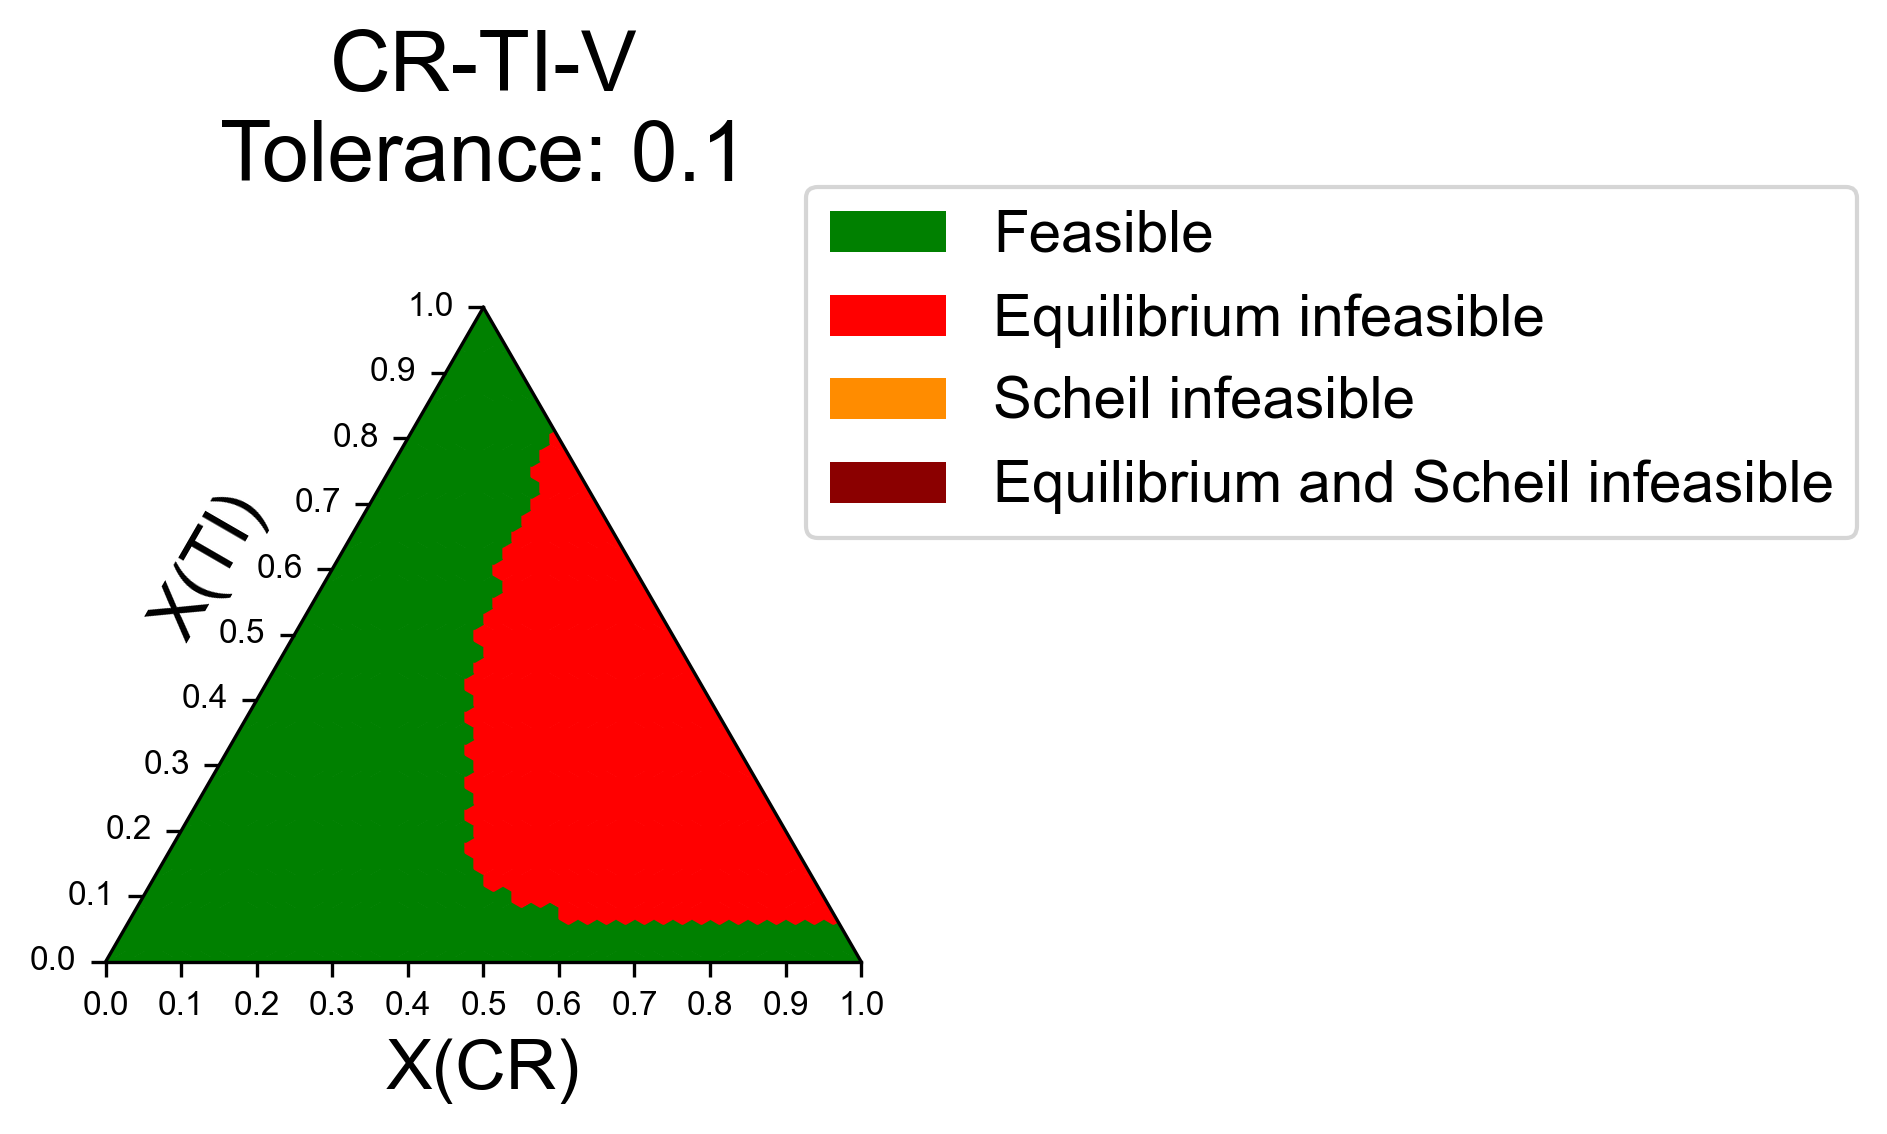

In [7]:
ax = plot_figure(comps, compositions_list, equilibrium_results, scheil_results, allowed_phases, tolerance_deleterious_phases)

ax.figure.savefig(os.path.join(OUTDIR, f"{'-'.join(sorted(set(comps) - {'VA'}))}.pdf"), bbox_inches='tight')

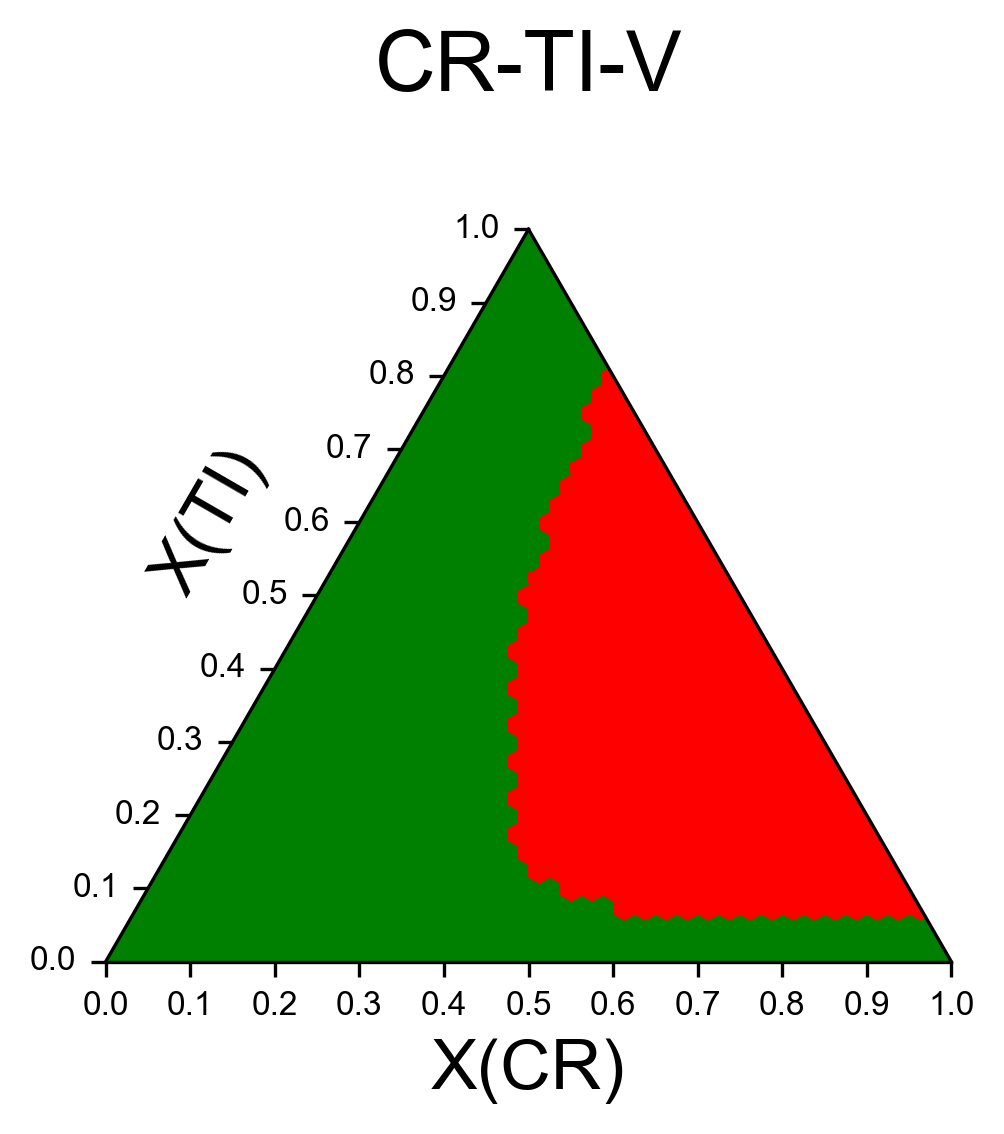

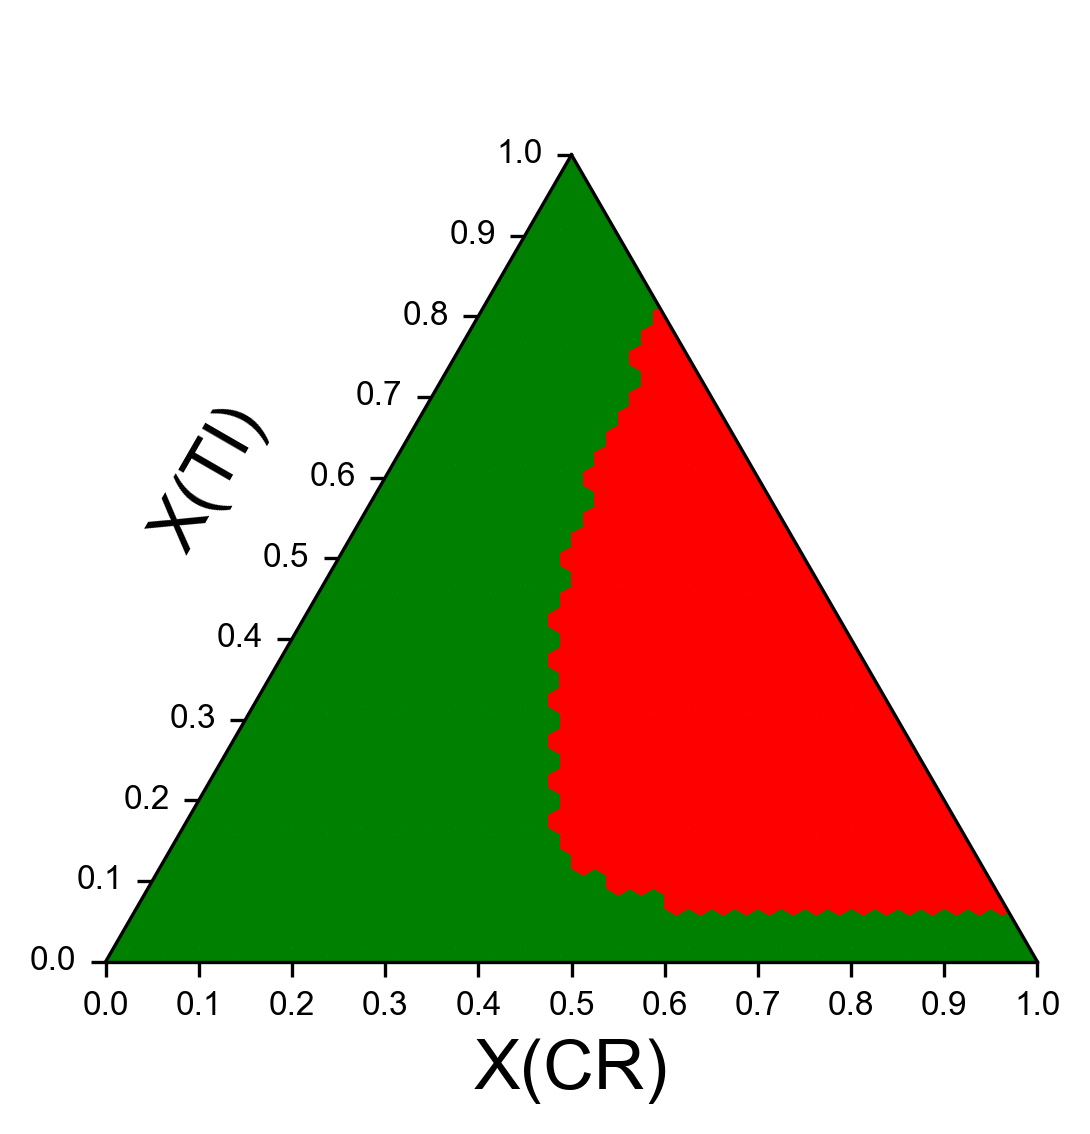

In [8]:
# with title
ax = plot_figure(comps, compositions_list, equilibrium_results, scheil_results, allowed_phases, tolerance_deleterious_phases, scattersize=27)
ax.figure.legends[0].remove()
ax.set_title(f"{'-'.join(sorted(set(comps) - {'VA'}))}")
ax.figure.savefig(os.path.join(OUTDIR, f"{'-'.join(sorted(set(comps) - {'VA'}))}.pdf"), bbox_inches='tight')

# without title
ax = plot_figure(comps, compositions_list, equilibrium_results, scheil_results, allowed_phases, tolerance_deleterious_phases, scattersize=33)
ax.figure.legends[0].remove()
ax.set_title("")
ax.figure.savefig(os.path.join(OUTDIR, f"{'-'.join(sorted(set(comps) - {'VA'}))}-notitle.pdf"), bbox_inches='tight')

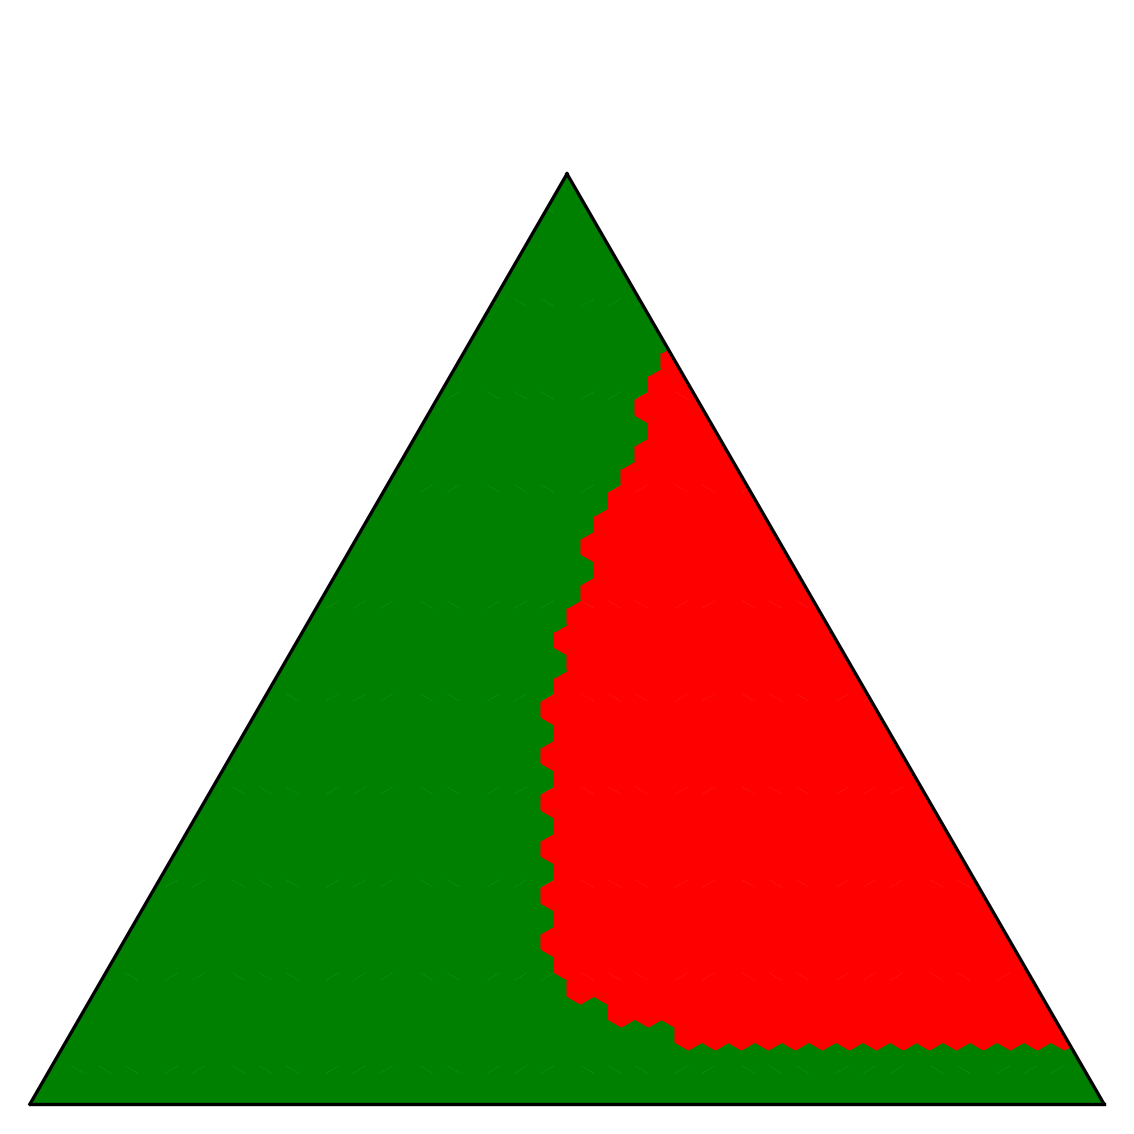

In [9]:
ax = plot_figure(comps, compositions_list, equilibrium_results, scheil_results, allowed_phases, tolerance_deleterious_phases, scattersize=44)
ax.figure.legends[0].remove()
ax.set_title("")
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_xticklabels([])
ax.set_xticks([])
ax.set_yticklabels([])
ax.set_yticks([])
ax.figure.savefig(os.path.join(OUTDIR, f"{'-'.join(sorted(set(comps) - {'VA'}))}-clean.pdf"), bbox_inches='tight')

In [1]:
import os
import time

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from pycalphad import Database, equilibrium, Model, variables as v
from pycalphad.core.calculate import _sample_phase_constitution
from pycalphad.core.utils import point_sample
from pycalphad.core.errors import DofError
from scheil import simulate_scheil_solidification
from feasibility_helpers import _build_composition_list, _build_mass_balanced_grid,  get_amount_disallowed_phases, get_amount_disallowed_phases_scheil

## User settings (edit these):
Be careful not to edit the variable names, because they are used below.


In [2]:
DATABASE_DIR = '../databases'
dbf = Database(os.path.join(DATABASE_DIR, 'Cr-Ti-V_ghosh2002.tdb'))
comps = ['CR', 'TI', 'V', 'VA']
phases = list(dbf.phases.keys())

T_liquid = 2200  # temperature where everything is liquid
potentials = {v.N: 1, v.T: (1000, T_liquid, 10), v.P: 101325}  # for equilibrium calculations

indep_comps = [comps[1], comps[2]]  # choose them automatically
ngridpts = 21  # number of points along each dimension of the composition grid

allowed_phases = ['LIQUID', 'BCC_A2', 'FCC_A1', 'HCP_A3']  # phases that are okay to have (non-deleterious)
liquid_phase_name = 'LIQUID'
tolerance_deleterious_phases = 0.10  # Maximum tolerance for deleterious phases

ADAPTIVE_MODE = False
SAVE_TIME = False  # If true, don't perform more expensive feasibility tests (e.g. Scheil) if the composition is already known to be infeasible (e.g. from equilibrium)
OUTDIR = 'figures'

In [3]:
## For users: sanity check that T_liquid is in fact liquid at every composition

conds = {v.P: 101325, v.N: 1, v.T: T_liquid, v.X(comps[0]): (0, 1, 0.02), v.X(comps[1]): (0, 1, 0.02)}
eq_res = equilibrium(dbf, comps, phases, conds)
non_liquid_phases = sorted(set(map(str, set(eq_res.Phase.where(~eq_res.Phase.isin([liquid_phase_name, ''])).values.flatten().tolist()))) - {'nan'})
assert len(non_liquid_phases) == 0, f"Got non-liquid phases {non_liquid_phases} at {T_liquid}"

## Script (should not need editing)

Setup

In [4]:
try:
    os.mkdir(OUTDIR)
except FileExistsError:
    pass
plt.style.use('papers.mplstyle')

# Generate points for adaptive Scheil starting points (performance)
if ADAPTIVE_MODE:
    points_dict = {}
    for phase_name in phases:
        try:
            mod = Model(dbf, comps, phase_name)
            points_dict[phase_name] = _sample_phase_constitution(mod, point_sample, True, 50)
        except DofError:
            pass
else:
    points_dict = None

# Build compositions to simulate over
grid_comps = _build_mass_balanced_grid(len(indep_comps), ngridpts)
compositions_list = _build_composition_list(indep_comps, grid_comps)

Run simulations

In [5]:
# Run simulations
eq_results = []  # List[xarray.Dataset]
scheil_results = []  # List[Optional[scheil.SolidificationResult]]
for num, composition in enumerate(compositions_list):
    print(f"{composition} ({num+1}/{len(compositions_list)})")
    # Equilibrium calculation for feasibility
    conds = {v.P: 101325, v.N: 1, v.T: (1000, 2200, 10), **composition}
    tick = time.time()
    eq_res = equilibrium(dbf, comps, phases, conds)
    tock = time.time()
    eq_results.append(eq_res)
    eq_is_feasible = get_amount_disallowed_phases(eq_res, allowed_phases).max() < tolerance_deleterious_phases
    print(f'Equilibrium time: {tock - tick: 0.2f} s - {"feasible" if eq_is_feasible else "infeasible"}')

    if SAVE_TIME and not eq_is_feasible:
        scheil_results.append(None)  # ensure that the shapes of the results line up, even if we don't do this calculation
        continue
    # Scheil
    tick = time.time()
    if ADAPTIVE_MODE:
        sol_res = simulate_scheil_solidification(dbf, comps, phases, composition, T_liquid, adaptive=True, eq_kwargs={'calc_opts': {'points': points_dict}}, liquid_phase_name=liquid_phase_name)
    else:
        sol_res = simulate_scheil_solidification(dbf, comps, phases, composition, T_liquid, liquid_phase_name=liquid_phase_name)
    tock = time.time()
    scheil_results.append(sol_res)
    scheil_is_feasible = get_amount_disallowed_phases_scheil(sol_res, allowed_phases) < tolerance_deleterious_phases
    print(f'Scheil time: {tock - tick: 0.2f} s - {"feasible" if scheil_is_feasible else "infeasible"}')

print('Done simulating')

{X_TI: 0.0001, X_V: 0.0001} (1/231)
Equilibrium time:  0.36 s - feasible
Scheil time:  0.45 s - feasible
{X_TI: 0.050085000000000005, X_V: 0.0001} (2/231)
Equilibrium time:  0.23 s - feasible
Scheil time:  4.07 s - feasible
{X_TI: 0.10007, X_V: 0.0001} (3/231)
Equilibrium time:  0.26 s - infeasible
Scheil time:  4.04 s - feasible
{X_TI: 0.150055, X_V: 0.0001} (4/231)
Equilibrium time:  0.23 s - infeasible
Scheil time:  4.06 s - feasible
{X_TI: 0.20004, X_V: 0.0001} (5/231)
Equilibrium time:  0.30 s - infeasible
Scheil time:  4.09 s - feasible
{X_TI: 0.250025, X_V: 0.0001} (6/231)
Equilibrium time:  0.96 s - infeasible
Scheil time:  3.94 s - feasible
{X_TI: 0.30001, X_V: 0.0001} (7/231)
Equilibrium time:  2.67 s - infeasible
Scheil time:  3.97 s - feasible
{X_TI: 0.349995, X_V: 0.0001} (8/231)
Equilibrium time:  0.25 s - infeasible
Scheil time:  3.99 s - feasible
{X_TI: 0.39998, X_V: 0.0001} (9/231)
Equilibrium time:  0.23 s - infeasible
Scheil time:  3.93 s - feasible
{X_TI: 0.449965, 

In [39]:
tolerance_deleterious_phases = 0.1

Plot feasibility on a ternary triangular diagram

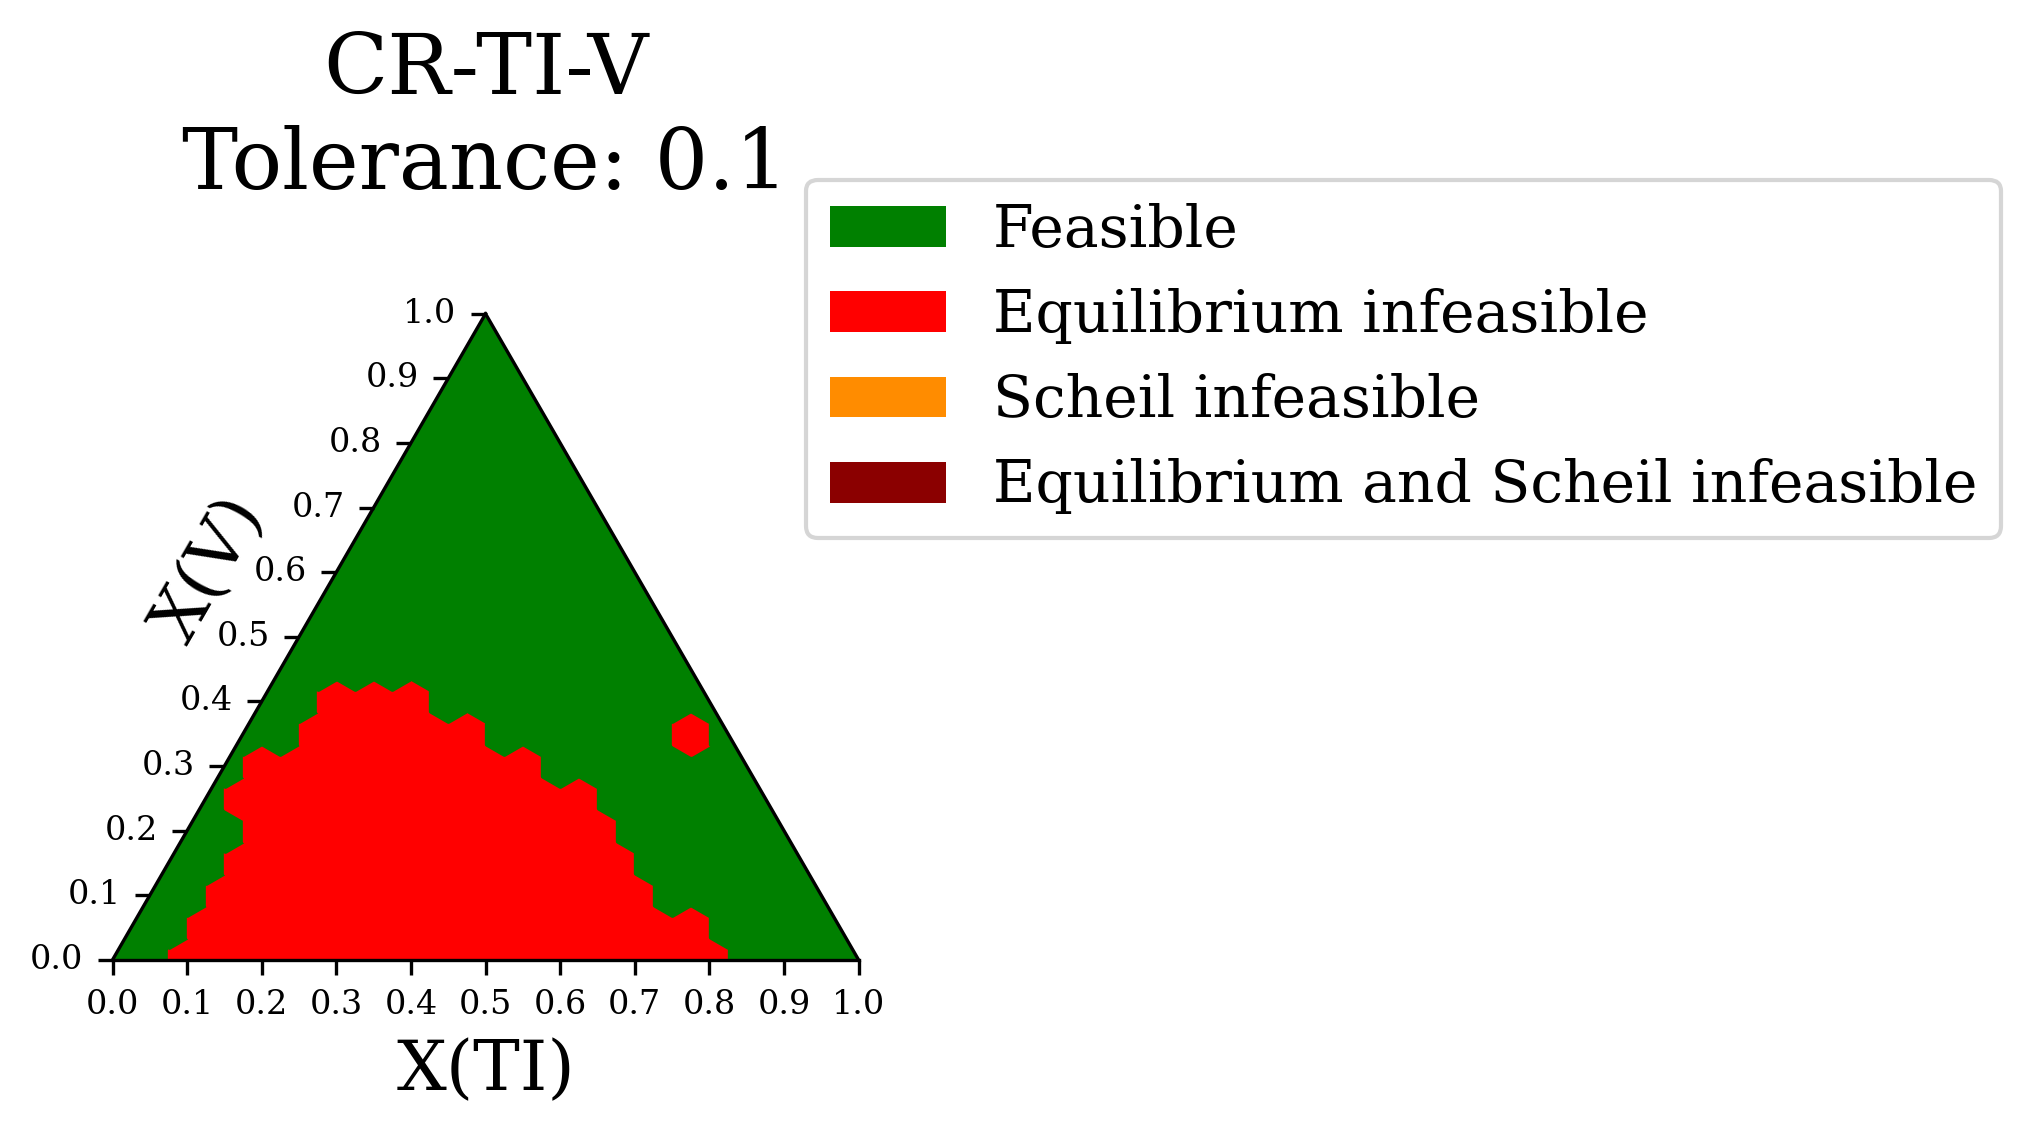

In [40]:
# Plot feasibility on a ternary triangular diagram

scattersize = 95
scattermarker = 'h'

indep_comp_vars = [v.X(ic) for ic in indep_comps]
handles = [
    mpl.patches.Patch(facecolor='green'),
    mpl.patches.Patch(facecolor='red'),
    mpl.patches.Patch(facecolor='darkorange'),
    mpl.patches.Patch(facecolor='darkred'),
]
labels = [
    'Feasible',
    'Equilibrium infeasible',
    'Scheil infeasible',
    'Equilibrium and Scheil infeasible',
]

fig = plt.figure()
ax = fig.add_subplot(projection='triangular')
for composition, eq_result, scheil_result in zip(compositions_list, eq_results, scheil_results):
    x_plot, y_plot = composition[indep_comp_vars[0]], composition[indep_comp_vars[1]]


    eq_is_feasible = get_amount_disallowed_phases(eq_result, allowed_phases).max() < tolerance_deleterious_phases
    scheil_is_feasible = get_amount_disallowed_phases_scheil(scheil_result, allowed_phases) < tolerance_deleterious_phases

    if eq_is_feasible and scheil_is_feasible:
        ax.scatter(x_plot, y_plot, label='Equilibrium and Scheil feasible', c='green', s=scattersize, marker=scattermarker)
    elif not eq_is_feasible and scheil_is_feasible:
        ax.scatter(x_plot, y_plot, label='Equilibrium infeasible', c='red', s=scattersize, marker=scattermarker)
    elif eq_is_feasible and not scheil_is_feasible:
        ax.scatter(x_plot, y_plot, label='Scheil infeasible', c='darkorange', s=scattersize, marker=scattermarker)
    else:
        ax.scatter(x_plot, y_plot, label='Equilibrium and Scheil infeasible', c='darkred', s=scattersize, marker=scattermarker)


fmtted_comps = '-'.join(sorted(set(comps) - {'VA'}))
ax.set_title(f"{fmtted_comps}\nTolerance: {tolerance_deleterious_phases}")
ax.set_xlabel(f'X({indep_comps[0]})')
ax.set_ylabel(f'X({indep_comps[1]})', labelpad=-50)
fig.legend(handles=handles, labels=labels, loc='lower left', bbox_to_anchor=(0.45, 0.5))
ax.tick_params(labelsize=8)

fig.savefig(os.path.join(OUTDIR, f'{fmtted_comps}.pdf'), bbox_inches='tight')